In [1]:
import zipfile
import random
import tensorflow as tf
from tensorflow import keras
import h5py
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *

from keras import optimizers
import scipy
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import imageio
import pandas as pd
from keras.models import *



2024-10-06 09:17:05.182778: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 09:17:05.182881: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 09:17:05.303740: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
all_data_dir  = '/kaggle/input/alzheimer-mri-4-classes-dataset/Alzheimer_MRI_4_classes_dataset'



# Classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
Classes = ['MildDemented', 'ModerateDemented', 'NonDemented']

print(os.listdir(all_data_dir))


['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']


In [3]:
all_images = []
all_labels = []

for folder in os.listdir(all_data_dir):
    subfolder_path2=os.path.join(all_data_dir,folder)
    for image_filename in os.listdir(subfolder_path2):
        image_path = os.path.join(subfolder_path2, image_filename)
        all_images.append(image_path)
        all_labels.append(folder)
all_df = pd.DataFrame({'image': all_images, 'label': all_labels})
all_df

image             label
0     /kaggle/input/alzheimer-mri-4-classes-dataset/...  ModerateDemented
1     /kaggle/input/alzheimer-mri-4-classes-dataset/...  ModerateDemented
2     /kaggle/input/alzheimer-mri-4-classes-dataset/...  ModerateDemented
3     /kaggle/input/alzheimer-mri-4-classes-dataset/...  ModerateDemented
4     /kaggle/input/alzheimer-mri-4-classes-dataset/...  ModerateDemented
...                                                 ...               ...
6395  /kaggle/input/alzheimer-mri-4-classes-dataset/...      MildDemented
6396  /kaggle/input/alzheimer-mri-4-classes-dataset/...      MildDemented
6397  /kaggle/input/alzheimer-mri-4-classes-dataset/...      MildDemented
6398  /kaggle/input/alzheimer-mri-4-classes-dataset/...      MildDemented
6399  /kaggle/input/alzheimer-mri-4-classes-dataset/...      MildDemented

[6400 rows x 2 columns]

In [4]:
all_df['label'].value_counts()

label
NonDemented         3200
VeryMildDemented    2240
MildDemented         896
ModerateDemented      64
Name: count, dtype: int64

In [5]:
all_df['label'] = all_df['label'].replace({'MildDemented': 'ModerateDemented'})
all_df['label'] = all_df['label'].replace({'VeryMildDemented': 'MildDemented'})
all_df['label'].value_counts()

label
NonDemented         3200
MildDemented        2240
ModerateDemented     960
Name: count, dtype: int64

In [6]:
all_df_edited = all_df[(all_df['label']=='MildDemented') | (all_df['label']=='ModerateDemented') | (all_df['label']=='NonDemented')]


all_df_edited = all_df_edited.sample(frac=1, random_state=44).reset_index(drop=True)
all_df_edited.head()

image             label
0  /kaggle/input/alzheimer-mri-4-classes-dataset/...       NonDemented
1  /kaggle/input/alzheimer-mri-4-classes-dataset/...      MildDemented
2  /kaggle/input/alzheimer-mri-4-classes-dataset/...  ModerateDemented
3  /kaggle/input/alzheimer-mri-4-classes-dataset/...  ModerateDemented
4  /kaggle/input/alzheimer-mri-4-classes-dataset/...       NonDemented

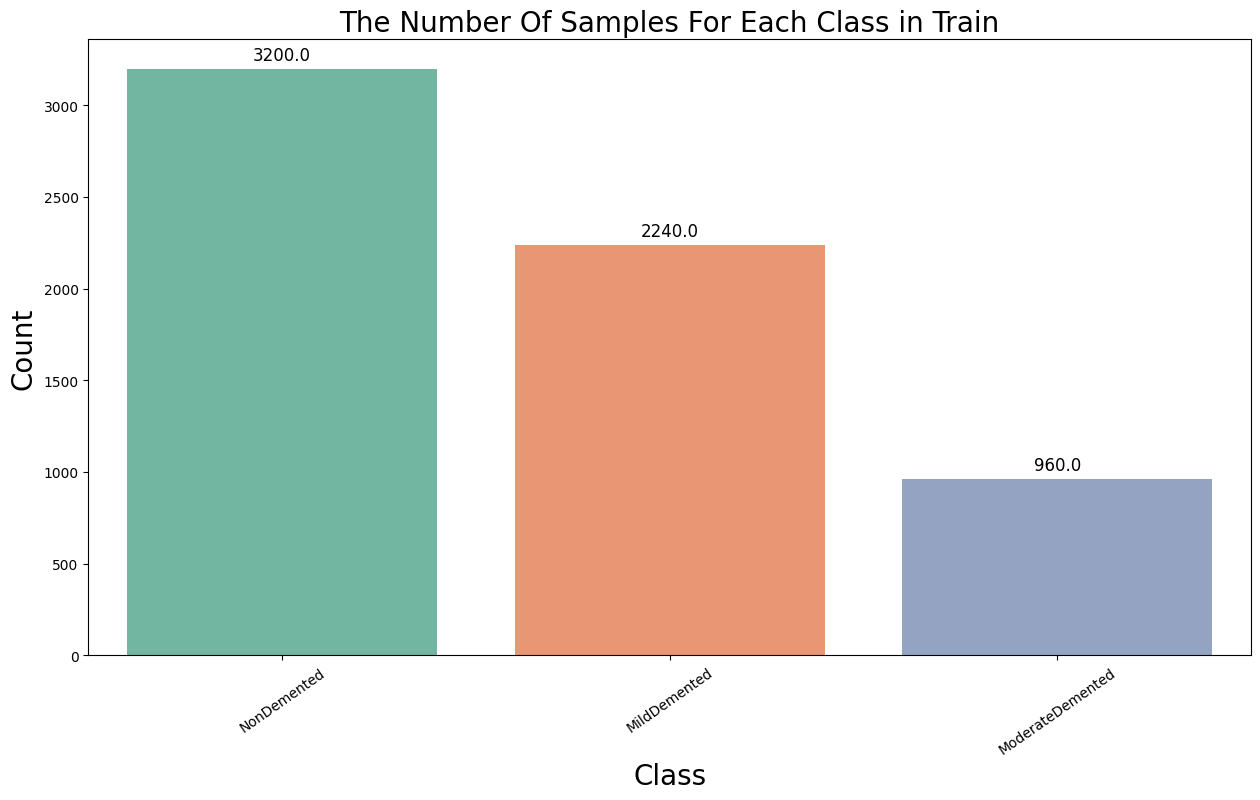

In [7]:
plt.figure(figsize=(15, 8))
ax = sns.countplot(x=all_df_edited.label, palette='Set2')
ax.set_xlabel("Class", fontsize=20)
ax.set_ylabel("Count", fontsize=20)
plt.title('The Number Of Samples For Each Class in Train', fontsize=20)
plt.grid(False)
plt.xticks(rotation=35)

# Add counts on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points', 
                fontsize=12)

plt.show()

In [8]:
temp_df_edited, test_df_edited = train_test_split(all_df_edited, test_size=0.15, stratify=all_df_edited['label'], random_state=42)
train_df_edited, val_df_edited = train_test_split(temp_df_edited, test_size=0.15, stratify=temp_df_edited['label'], random_state=42)


train_df_edited = train_df_edited.reset_index(drop=True)
val_df_edited = val_df_edited.reset_index(drop=True)
test_df_edited = test_df_edited.reset_index(drop=True)
train_df_edited.shape, test_df_edited.shape, val_df_edited.shape

((4624, 2), (960, 2), (816, 2))

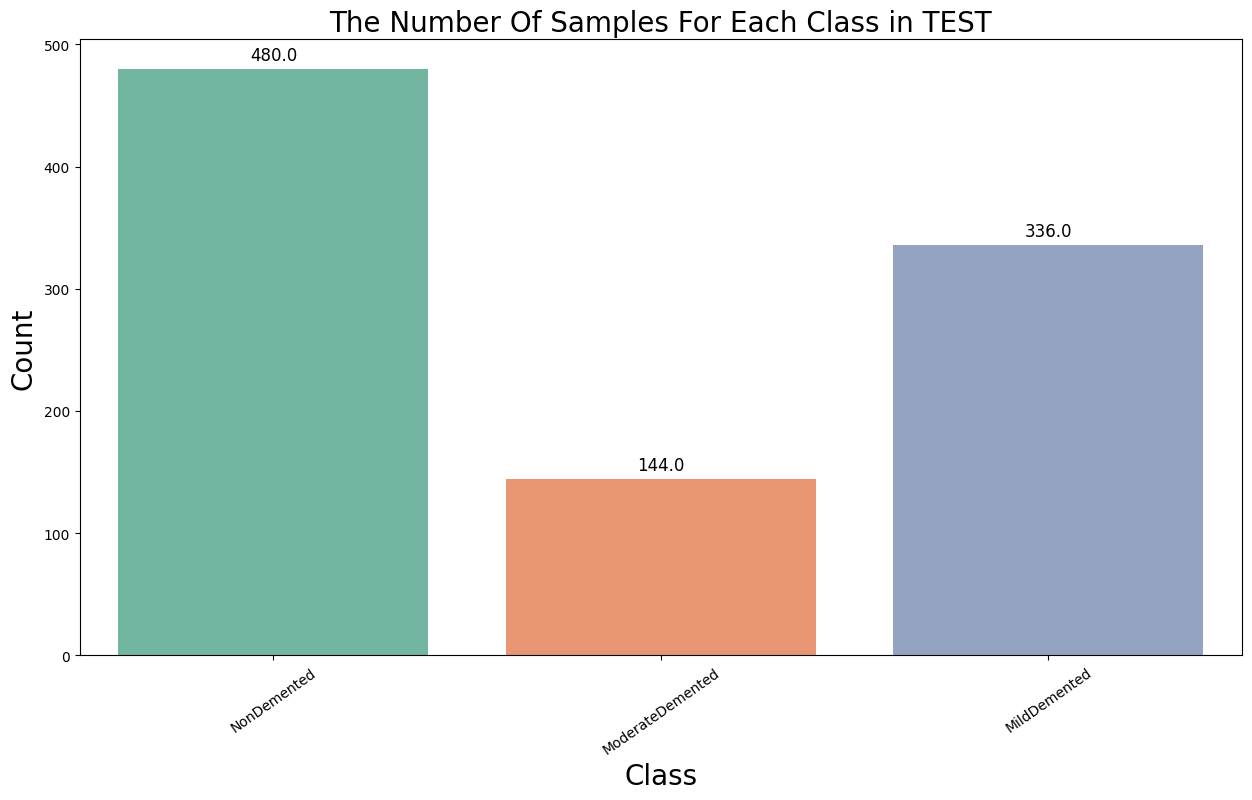

In [9]:
plt.figure(figsize=(15, 8))
ax = sns.countplot(x=test_df_edited.label, palette='Set2')
ax.set_xlabel("Class", fontsize=20)
ax.set_ylabel("Count", fontsize=20)
plt.title('The Number Of Samples For Each Class in TEST', fontsize=20)
plt.grid(False)
plt.xticks(rotation=35)

# Add counts on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points', 
                fontsize=12)

plt.show()

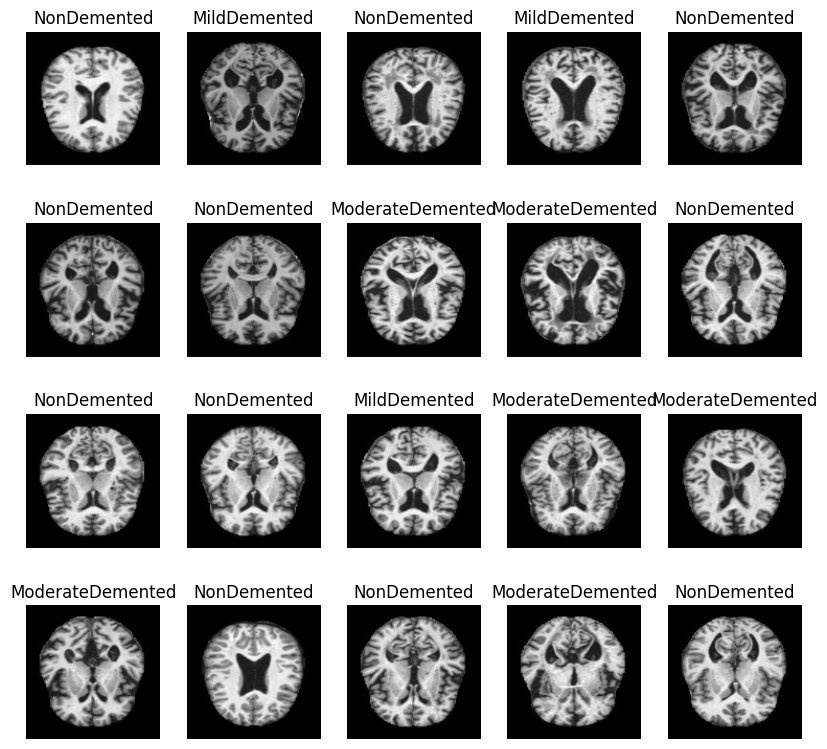

In [10]:
plt.figure(figsize=(10,12))

for n,i in enumerate(np.random.randint(0,len(train_df_edited),20)):
    plt.subplot(5,5,n+1)
    img=cv2.imread(train_df_edited.image[i])
    img=cv2.resize(img,(128,128))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(train_df_edited.label[i],fontsize=12)

In [11]:
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.utils import to_categorical

In [12]:
def load_resize_normalize_data(df, target_size=(128, 128)):
    images = []
    labels = []
    
    label_encoder = LabelEncoder()
    for index, row in df.iterrows():
   
        image_path = row['image']
        image = cv2.imread(image_path)
        

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
        resized_image = cv2.resize(image_rgb, (128,128))
        

        normalized_image = resized_image / 255.0 
        
        # Store the resized and normalized image and its corresponding label
        images.append(normalized_image)
        labels.append(row['label'])
  
    encoded_labels_lb = label_encoder.fit_transform(labels)
    
    class_mapping ={  'MildDemented':0,'ModerateDemented':1, 'NonDemented': 2, }
    
    y_mapped =df['label'].map(class_mapping)
    y_one_hot = to_categorical(y_mapped, num_classes=3)
    return np.array(images), np.array(encoded_labels_lb), label_encoder.classes_, y_one_hot




In [13]:
train_images, train_encoded_labels, classes, train_one_hot = load_resize_normalize_data(train_df_edited)



In [14]:
train_datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, 
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2, 
     horizontal_flip=True)

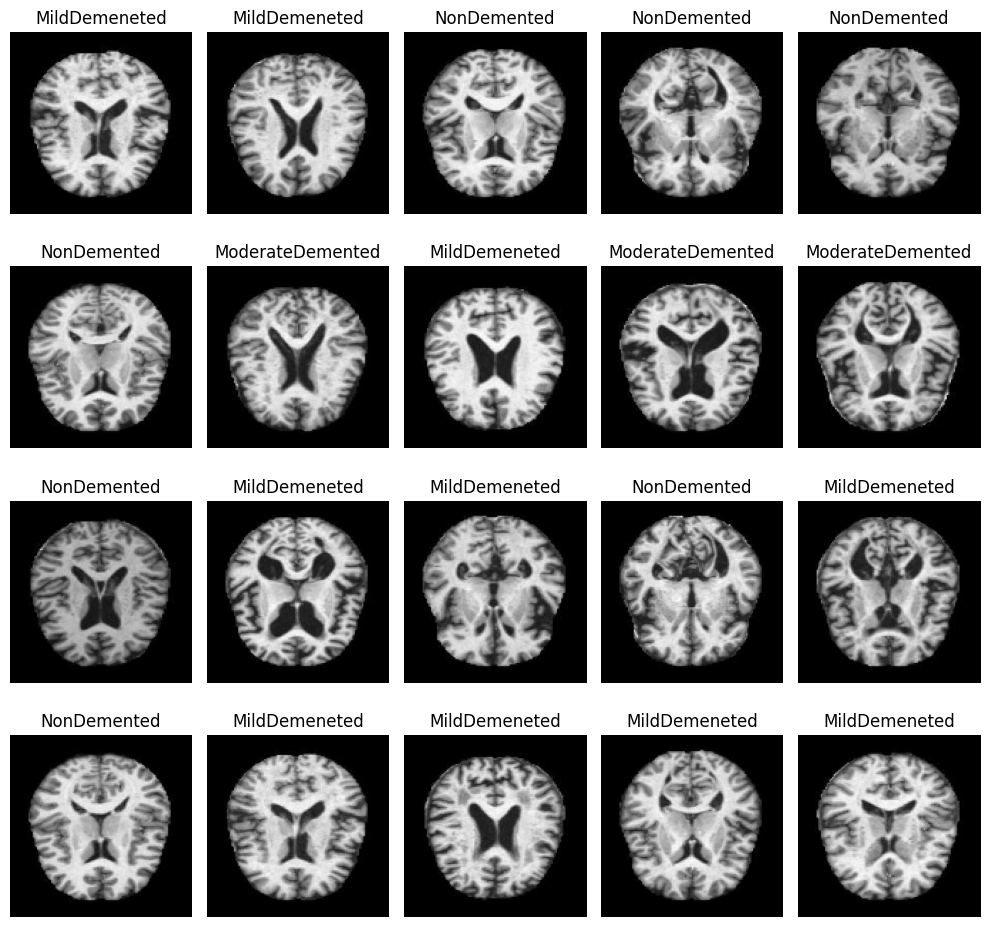

In [15]:
label_decoder = {0:'MildDemeneted', 1: 'ModerateDemented', 2: 'NonDemented'}

plt.figure(figsize=(10, 12))

for n, i in enumerate(np.random.randint(0, len(train_images), 20)):
    plt.subplot(5, 5, n + 1)
    img = train_images[i]
    plt.imshow(img)
    plt.axis('off')
    plt.title(label_decoder[train_encoded_labels[i]], fontsize=12)

plt.tight_layout()

In [16]:
train_df_edited['label'].value_counts()

label
NonDemented         2312
MildDemented        1618
ModerateDemented     694
Name: count, dtype: int64

In [17]:
df_train = pd.DataFrame({'image': list(train_images), 'label': train_encoded_labels})


minority_class = df_train[df_train['label'] == 1]
majority_class = df_train[df_train['label'] == 0]


num_to_augment = 1100#len(majority_class) - len(minority_class)

minority_images = np.array(minority_class['image'].tolist())
minority_labels = np.array(minority_class['label'].tolist())

In [18]:
num_to_augment

1100

In [19]:
augmented_minority_images=[]
augmented_minority_labels=[]

In [20]:
total_augmented_images = 0
batch_size = 8

while total_augmented_images < num_to_augment:

    batch_images, batch_labels = next(train_datagen.flow(minority_images, minority_labels, batch_size=batch_size))

    remaining_to_augment = num_to_augment - total_augmented_images
    images_to_add = min(remaining_to_augment, batch_size)
    
    augmented_minority_images.extend(batch_images[:images_to_add])
    augmented_minority_labels.extend(batch_labels[:images_to_add])
    
    total_augmented_images += images_to_add

    if total_augmented_images % 200 == 0:
        print(f'{total_augmented_images} images augmented so far')

200 images augmented so far
400 images augmented so far
600 images augmented so far
800 images augmented so far
1000 images augmented so far


In [21]:
balanced_images = np.concatenate((minority_images, augmented_minority_images), axis=0)
balanced_labels = np.concatenate((minority_labels, augmented_minority_labels), axis=0)


In [22]:
balanced_images.shape, balanced_labels.shape

((1794, 128, 128, 3), (1794,))

In [23]:
balanced_labels

array([1, 1, 1, ..., 1, 1, 1])

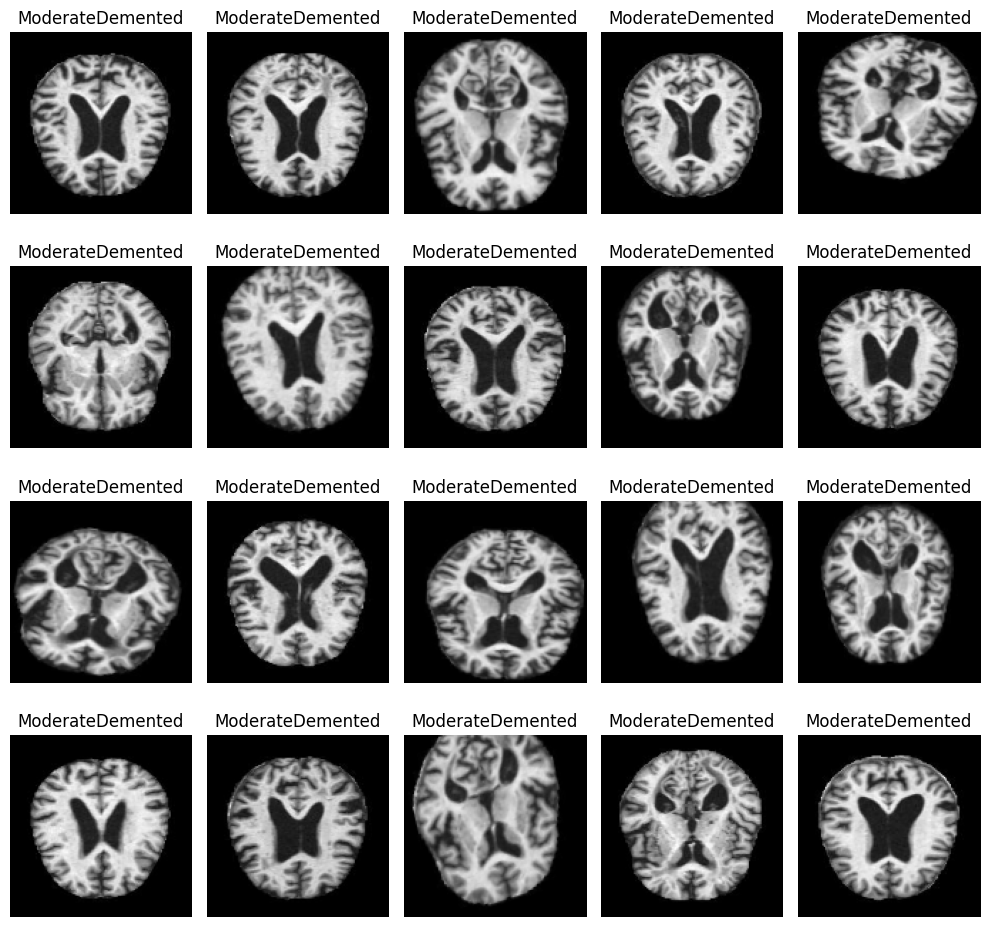

In [24]:
label_decoder = {0:'MildDemeneted', 1: 'ModerateDemented', 2: 'NonDemented'}

plt.figure(figsize=(10, 12))

for n, i in enumerate(np.random.randint(0, len(balanced_images), 20)):
    plt.subplot(5, 5, n + 1)
    img = balanced_images[i]
    plt.imshow(img)
    plt.axis('off')
    plt.title(label_decoder[balanced_labels[i]], fontsize=12)

plt.tight_layout()
plt.show()

In [25]:
majority_class = df_train[(df_train['label'] == 0)|(df_train['label'] == 2) ]



majority_images = np.array(majority_class['image'].tolist())
majority_labels = np.array(majority_class['label'].tolist())
majority_images.shape, majority_labels.shape

((3930, 128, 128, 3), (3930,))

In [26]:
train_df_edited['label'].value_counts()

label
NonDemented         2312
MildDemented        1618
ModerateDemented     694
Name: count, dtype: int64

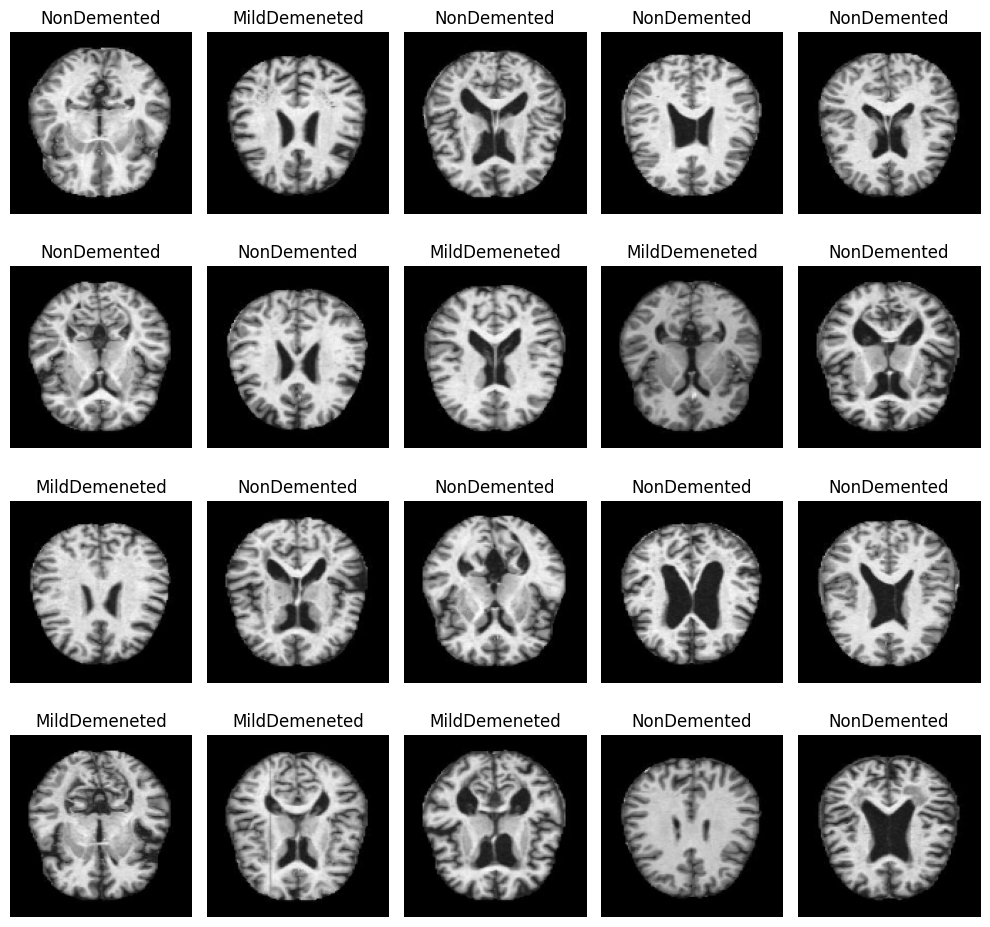

In [27]:
label_decoder = {0:'MildDemeneted', 1: 'ModerateDemented', 2: 'NonDemented'}

plt.figure(figsize=(10, 12))

for n, i in enumerate(np.random.randint(0, len(majority_images), 20)):
    plt.subplot(5, 5, n + 1)
    img = majority_images[i]
    plt.imshow(img)
    plt.axis('off')
    plt.title(label_decoder[majority_labels[i]], fontsize=12)

plt.tight_layout()
plt.show()

In [28]:
all_train_images= np.concatenate((majority_images, balanced_images), axis=0)
all_train_labels= np.concatenate((majority_labels, balanced_labels), axis=0)
all_train_images.shape, all_train_labels.shape

((5724, 128, 128, 3), (5724,))

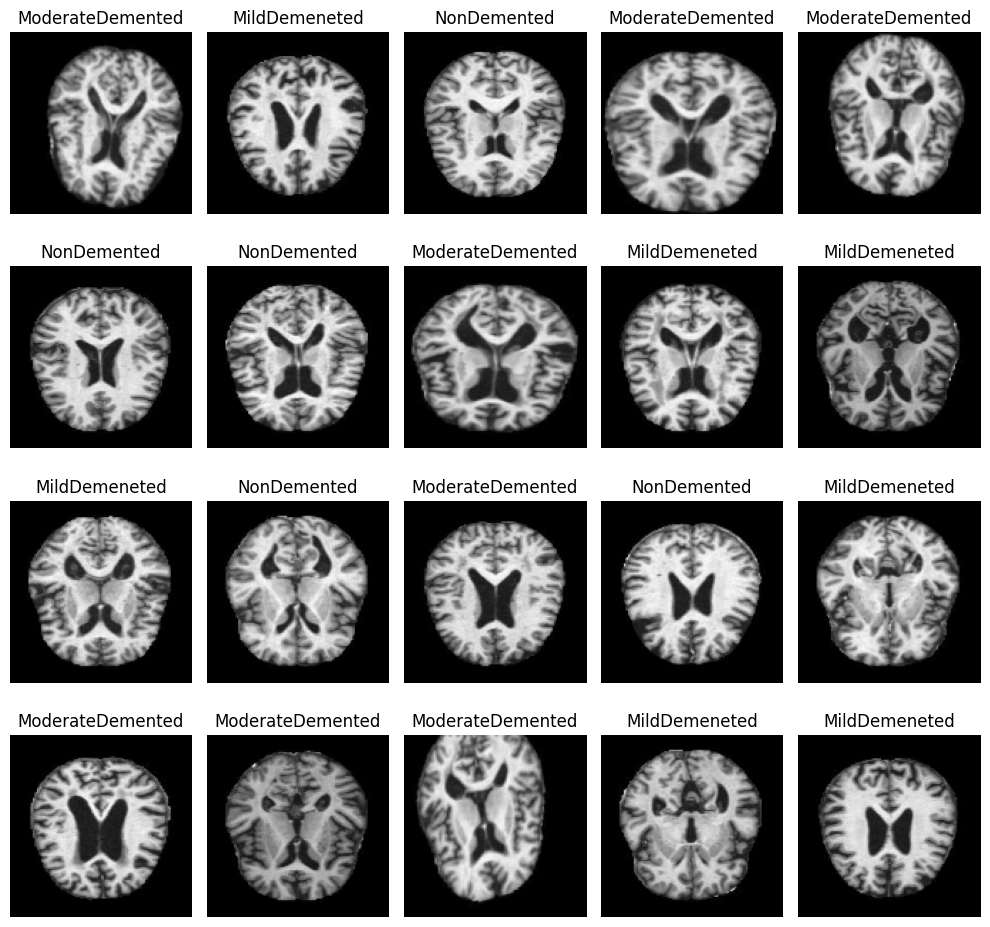

In [29]:
label_decoder = {0:'MildDemeneted', 1: 'ModerateDemented', 2: 'NonDemented'}

plt.figure(figsize=(10, 12))

for n, i in enumerate(np.random.randint(0, len(all_train_images), 20)):
    plt.subplot(5, 5, n + 1)
    img = all_train_images[i]
    plt.imshow(img)
    plt.axis('off')
    plt.title(label_decoder[all_train_labels[i]], fontsize=12)

plt.tight_layout()
plt.show()

In [30]:
print("Shape of images array:", all_train_images.shape)
print("Shape of encoded labels array:", all_train_labels.shape)
print("Classes:", classes)
# print("One HOt clases:", train_one_hot)
# print("One HOt clases:", train_one_hot.shape)

Shape of images array: (5724, 128, 128, 3)
Shape of encoded labels array: (5724,)
Classes: ['MildDemented' 'ModerateDemented' 'NonDemented']


# Val Processing

In [31]:
val_images, val_encoded_labels, val_classes, val_one_hot = load_resize_normalize_data(val_df_edited)



In [32]:
print("Shape of images array:", val_images.shape)
print("Shape of encoded labels array:", val_encoded_labels.shape)
print("Classes:", val_classes)
# print("One HOt clases:", val_one_hot)
print("One HOt clases:", val_one_hot.shape)

Shape of images array: (816, 128, 128, 3)
Shape of encoded labels array: (816,)
Classes: ['MildDemented' 'ModerateDemented' 'NonDemented']
One HOt clases: (816, 3)


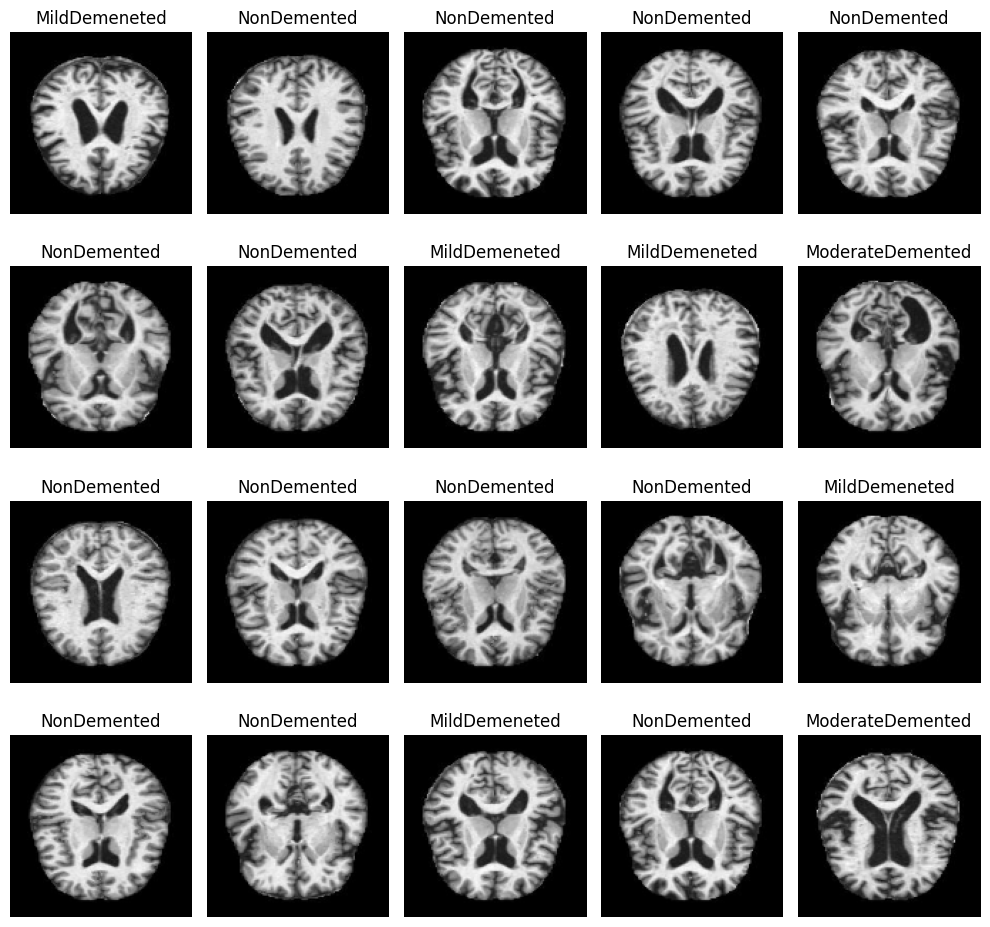

In [33]:
label_decoder = {0:'MildDemeneted', 1: 'ModerateDemented', 2: 'NonDemented'}

plt.figure(figsize=(10, 12))

for n, i in enumerate(np.random.randint(0, len(val_images), 20)):
    plt.subplot(5, 5, n + 1)
    img = val_images[i]
    plt.imshow(img)
    plt.axis('off')
    plt.title(label_decoder[val_encoded_labels[i]], fontsize=12)

plt.tight_layout()
plt.show()

# val preprocessing

In [34]:
test_images, test_encoded_labels, test_classes, test_one_hot = load_resize_normalize_data(test_df_edited)



In [35]:
print("Shape of images array:", test_images.shape)
print("Shape of encoded labels array:", test_encoded_labels.shape)
print("Classes:", test_classes)
# print("One HOt clases:", test_one_hot)
print("One HOt clases:", test_one_hot.shape)

Shape of images array: (960, 128, 128, 3)
Shape of encoded labels array: (960,)
Classes: ['MildDemented' 'ModerateDemented' 'NonDemented']
One HOt clases: (960, 3)


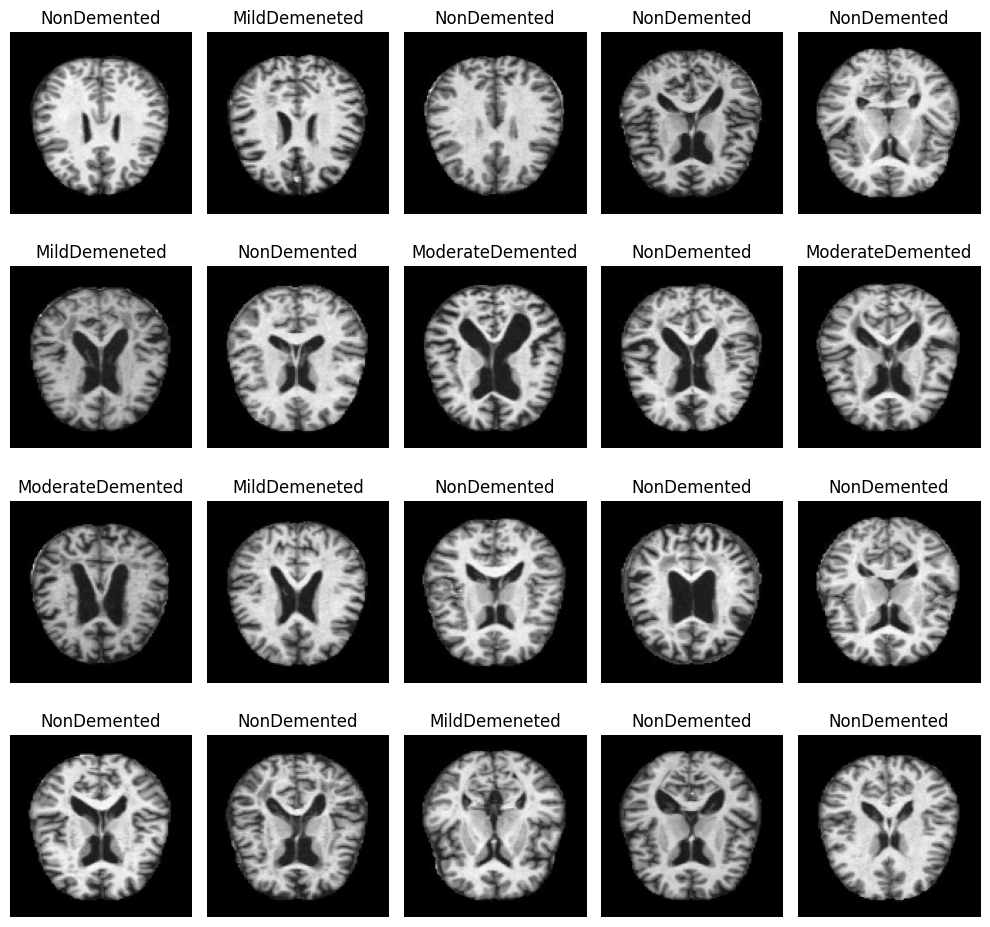

In [36]:
label_decoder = {0:'MildDemeneted', 1: 'ModerateDemented', 2: 'NonDemented'}

plt.figure(figsize=(10, 12))

for n, i in enumerate(np.random.randint(0, len(test_images), 20)):
    plt.subplot(5, 5, n + 1)
    img = test_images[i]
    plt.imshow(img)
    plt.axis('off')
    plt.title(label_decoder[test_encoded_labels[i]], fontsize=12)

plt.tight_layout()
plt.show()

In [37]:
all_train_labels


array([2, 0, 0, ..., 1, 1, 1])

In [38]:

all_train_one_hot = to_categorical(all_train_labels, num_classes=3)


In [39]:
# from sklearn.model_selection import train_test_split

# x_train, x_val, y_train, y_val= train_test_split(all_train_images, all_train_one_hot, test_size=0.20, random_state=43)

# x_train.shape, y_train.shape, x_val.shape, y_val.shape

# Data generator

In [40]:
valid_datagen = ImageDataGenerator(
    preprocessing_function=None 
)


In [41]:
batch_size=8
# train_gen = train_datagen.flow(all_train_images, all_train_one_hot, batch_size=8, shuffle=True)
val_gen = valid_datagen.flow(val_images, val_one_hot, batch_size=8, shuffle=False)
test_gen = valid_datagen.flow(test_images, test_one_hot, batch_size=1, shuffle=False)

In [42]:
from keras import backend as K

IMG_CHANNELS=3
IMG_WIDTH = 128
IMG_HEIGHT = 128

if K.image_data_format() == 'channels_first':
    input_shape = (IMG_CHANNELS, IMG_WIDTH, IMG_HEIGHT)
else:
    input_shape = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

In [43]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import *
initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(
        initial_learning_rate,
        decay_steps=10000,
        decay_rate=0.8,
        staircase=True)


print(lr_schedule.get_config())


{'initial_learning_rate': 0.0001, 'decay_steps': 10000, 'decay_rate': 0.8, 'staircase': True, 'name': 'ExponentialDecay'}


In [44]:
class ExpandDimsLayer(Layer):
    def __init__(self, axis, **kwargs):
        super(ExpandDimsLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)

In [45]:
class Reshapelayer(Layer):
    def __init__(self, dim, **kwargs):
        super(Reshapelayer, self).__init__(**kwargs)
        self.dim = dim

    def call(self, inputs):
        return tf.reshape(inputs, [tf.shape(inputs)[0], self.dim, 1])

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dim, 1)
    
    
class ReduceMeanLayer(Layer):
    def __init__(self, axis, **kwargs):
        super(ReduceMeanLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=self.axis)

In [46]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [47]:
class RootMeanSquaredError(tf.keras.metrics.Metric):
    def __init__(self, name='rmse', **kwargs):
        super(RootMeanSquaredError, self).__init__(name=name, **kwargs)
        self.mse = tf.keras.metrics.MeanSquaredError()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.mse.update_state(y_true, y_pred, sample_weight)

    def result(self):
        return tf.sqrt(self.mse.result())

    def reset_states(self):
        self.mse.reset_states()

In [48]:
class SpatialAttention(tf.keras.layers.Layer):
    def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size
        
    def build(self, input_shape):
        self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

    def call(self, inputs):
        avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)
            
            # MaxPool
        max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

        attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

        attention = self.conv2d(attention)


        return tf.keras.layers.multiply([inputs, attention])

In [49]:
def multires_block2D(U, x, alpha=1.67, strides=1):
    kernel_initializer = 'he_normal'
    W = U * alpha
    shortcut = Conv2D(int(W*0.167) + int(W*0.333) + int(W*0.5), kernel_size=(1, 1), padding='same',
                      use_bias=False, kernel_initializer=kernel_initializer)(x)
    
    # Multi-resolution paths with Conv2D
    conv6 = Conv2D(int(W*0.167), kernel_size=(3, 3), padding='same', use_bias=False,
                   kernel_initializer=kernel_initializer)(shortcut)
    conv11 = Conv2D(int(W*0.333), kernel_size=(3, 3), padding='same', use_bias=False,
                    kernel_initializer=kernel_initializer)(conv6)
    conv17 = Conv2D(int(W*0.5), kernel_size=(3, 3), padding='same', use_bias=False,
                    kernel_initializer=kernel_initializer)(conv11)
    
    # Concatenate the multi-resolution outputs
    out = tf.keras.layers.concatenate([conv6, conv11, conv17], axis=-1)
    out = LayerNormalization(axis=-1)(out, training=True)
    
    # Add the skip connection
    out = Add()([out, shortcut])
    
    # Final Conv2D layer with strides
    out = Conv2D(int(W*0.167) + int(W*0.333) + int(W*0.5), kernel_size=(5, 5), padding='same',
                 strides=strides, use_bias=False, kernel_initializer=kernel_initializer)(out)
    out = Activation('relu')(out)
    out = LayerNormalization(axis=-1)(out, training=True)
    
    return out

In [50]:
def line1(x):
    # received shape: (64, 64, 3)
    kernel_ ='he_normal'
    conv_1 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = kernel_)(x)

    
    block1_conv1 = Conv2D(32, (1, 1), activation='relu', padding='same', kernel_initializer = kernel_)(conv_1)
    block1_pool = MaxPool2D(2, 2)(block1_conv1)

    block2_conv1 = Conv2D(64, (7, 7), activation='relu', padding='same', kernel_initializer = kernel_)(block1_pool)
    block2_pool = MaxPool2D(2, 2)(block2_conv1)
  
    return block2_pool

def line2(x):
    # received shape: (32, 32, 3)


    conv_1 = Conv2D(16, (7, 7), activation='relu', padding='same')(x)
    conv_1 = BatchNormalization()(conv_1, training=True)
    conv_1 = Dropout(0.3)(conv_1)


    block1_conv1 = Conv2D(64, (5, 5), activation='relu', padding='same')(conv_1)
    block1_conv1 = BatchNormalization()(block1_conv1, training=True)
    block1_conv1 = MaxPool2D(2, 2)(block1_conv1)


    return block1_conv1

def line3(x):
    # received shape: (16, 16, 3)


    conv_1 = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    conv_1 = LayerNormalization()(conv_1)

    block1_conv1 = Conv2D(16, (2, 2), activation='relu', padding='same')(conv_1)
    block1_conv1 = LayerNormalization()(block1_conv1)

    block2_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(block1_conv1)
    block2_pool = AvgPool2D(2, 2)(block2_conv1)

    return block2_pool



def line4(x):
    conv_1 = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    conv_1 = Conv2D(64, (14, 14), activation='relu', padding='same')(conv_1)
    conv_1 = MaxPool2D(pool_size=(2,2))(conv_1)
    conv_1 = BatchNormalization()(conv_1, training=True)
#     reshaped = Reshape((conv_1.shape[1] * conv_1.shape[2], conv_1.shape[3]))(conv_1)
#     lstm_1 = LSTM(32, return_sequences=True)(reshaped)
#     query_attn = GroupQueryAttention(head_dim=128,num_query_heads=8,num_key_value_heads=4)
#     attention= query_attn(query =conv_1, value= conv_1)

    return conv_1

def line5(x):
    conv_1 = Conv2D(128, (5,5), activation='relu', padding='same')(x)
    conv_1 = Dropout(0.2)(conv_1)
    conv_1 = BatchNormalization()(conv_1)
    
    
    multires_block_1 = multires_block2D(U=32, x= conv_1)
    multires_block_1 = BatchNormalization()(multires_block_1)
    multires_block_1 = multires_block2D(U=64, x= multires_block_1)

    
    reshaped = Reshape((multires_block_1.shape[1] * multires_block_1.shape[2], multires_block_1.shape[3]))(multires_block_1)

    
  
    lstm1 = Bidirectional(LSTM(32, return_sequences=True))(reshaped)
#     out = Dense(128, activation='relu')(lstm1)
    return lstm1

In [51]:
def get_model(num_classes):
    
    signal = Input(shape=(128, 128, 3), dtype=np.float32, name='signal')
    


    # converting to (32, 32, 3):
    conv_1 = Conv2D(64, (5,5), activation='relu', padding='same', strides=1)(signal)
    conv_1 = MaxPool2D(pool_size=(2,2))(conv_1)  # (32, 32, 3)
    f1_conv= line1(conv_1)


    # converting to (16, 16, 3):
    conv_1 = Conv2D(256, (5, 5), activation='relu', padding='same', strides=1)(conv_1)
    conv_1 = MaxPool2D(pool_size=(2,2))(conv_1)  # (16, 16, 3)
    conv_1 = Conv2D(128, (9,9), activation='relu', padding='same', strides=1)(conv_1)
    f2_conv = line2(conv_1)
    spat_atten = SpatialAttention(8)
    f2_conv = spat_atten(f2_conv)
    
    concat_1 = keras.layers.concatenate([f1_conv, f2_conv], axis=-1)

    # converting to (8, 8, 3):
    

    conv_1 = Conv2D(128, (5, 5), activation='relu', padding='same', strides=1)(conv_1)
    conv_1 = MaxPool2D(2)(conv_1)  
    f3_conv= line3(conv_1)
    print(f3_conv.shape)
#     f3_conv_reshaped = Reshape((f3_conv.shape[1] * f3_conv.shape[2], f3_conv.shape[3]))(f3_conv)

    
    
    # converting to (8, 8, 3): # same input line4 function
    f4_conv= line4(conv_1)
    concat_2 = keras.layers.concatenate([f3_conv, f4_conv], axis=-1)
    
    concat_1 = Dropout(0.3)(concat_1)
    print(concat_1.shape, concat_2.shape)
    xm = MultiHeadAttention(num_heads=8, key_dim=32*8)(concat_1, concat_2)
    print(xm.shape)
    
    
    f_lstm = line5(conv_1)
    f5 = line5(xm)
#     concat_3 = Concatenate(axis=1)([f_lstm, f5])
    query_attn = GroupQueryAttention(head_dim=128,num_query_heads=8,num_key_value_heads=4)
    xm= query_attn(query =f5, value= f_lstm)

#     xm = MultiHeadAttention(num_heads=8, key_dim=32*8)(f5, f_lstm)
    block1_conv1 = Conv2D(64, (7, 7), activation='leaky_relu', padding='same')(ExpandDimsLayer(axis=-1)(xm))
    block1_conv1 = MaxPooling2D(pool_size=(3,3))(block1_conv1)
    block1_conv1 = LayerNormalization()(block1_conv1)
    block1_conv1 = Conv2D(32, (3,3), activation='leaky_relu', padding='same')(block1_conv1)
    block1_conv1 = MaxPooling2D(pool_size=(2,2))(block1_conv1)
    block1_conv1 = LayerNormalization()(block1_conv1)
    block1_conv1 = Conv2D(16, (5,5), activation='leaky_relu', padding='same')(block1_conv1)
    block1_conv1 = LayerNormalization()(block1_conv1)
    #concat = ReduceMeanLayer(axis=2)(concat)# old code
    avg_pool = GlobalAveragePooling2D()(block1_conv1)
#=====================================================================================
    dense_1 = Dense(128, activation='relu')(avg_pool)
    dense_1 = Dense(32, activation='relu')(dense_1)
    out = Dense(num_classes, activation='softmax')(dense_1)

    model = Model(inputs=signal, outputs=[out])
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),  metrics=[tf.keras.metrics.CategoricalAccuracy(
                    name='accuracy'),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(num_thresholds=200,curve="ROC",summation_method="interpolation",name="AUC",dtype=None,thresholds=None,
                    multi_label=True,label_weights=None,),
                    tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives(),
                    F1Score(name='f1_score'),
                    tf.keras.metrics.MeanAbsoluteError(name='MAE'),
                    tf.keras.metrics.MeanAbsolutePercentageError(name='MAPE'),
                    RootMeanSquaredError(name='RMSE')]) 
    
    return model

if __name__ == "__main__":
    model = get_model(3)
    model.summary()

(None, 8, 8, 64)
(None, 16, 16, 128) (None, 8, 8, 128)
(None, 16, 16, 128)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ signal (InputLayer) │ (None, 128, 128,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      4,864 │ signal[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    409,856 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │  2,654,336 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    100,368 │ conv2d_5[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │    409,728 │ conv2d_5[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │         64 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 16, 16, 8) │      9,224 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,128 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │     25,664 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 16, 16, 8) │         16 │ conv2d_10[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                 

 Total params: 7,293,415 (27.82 MB)

 Trainable params: 7,292,411 (27.82 MB)

 Non-trainable params: 1,004 (3.92 KB)

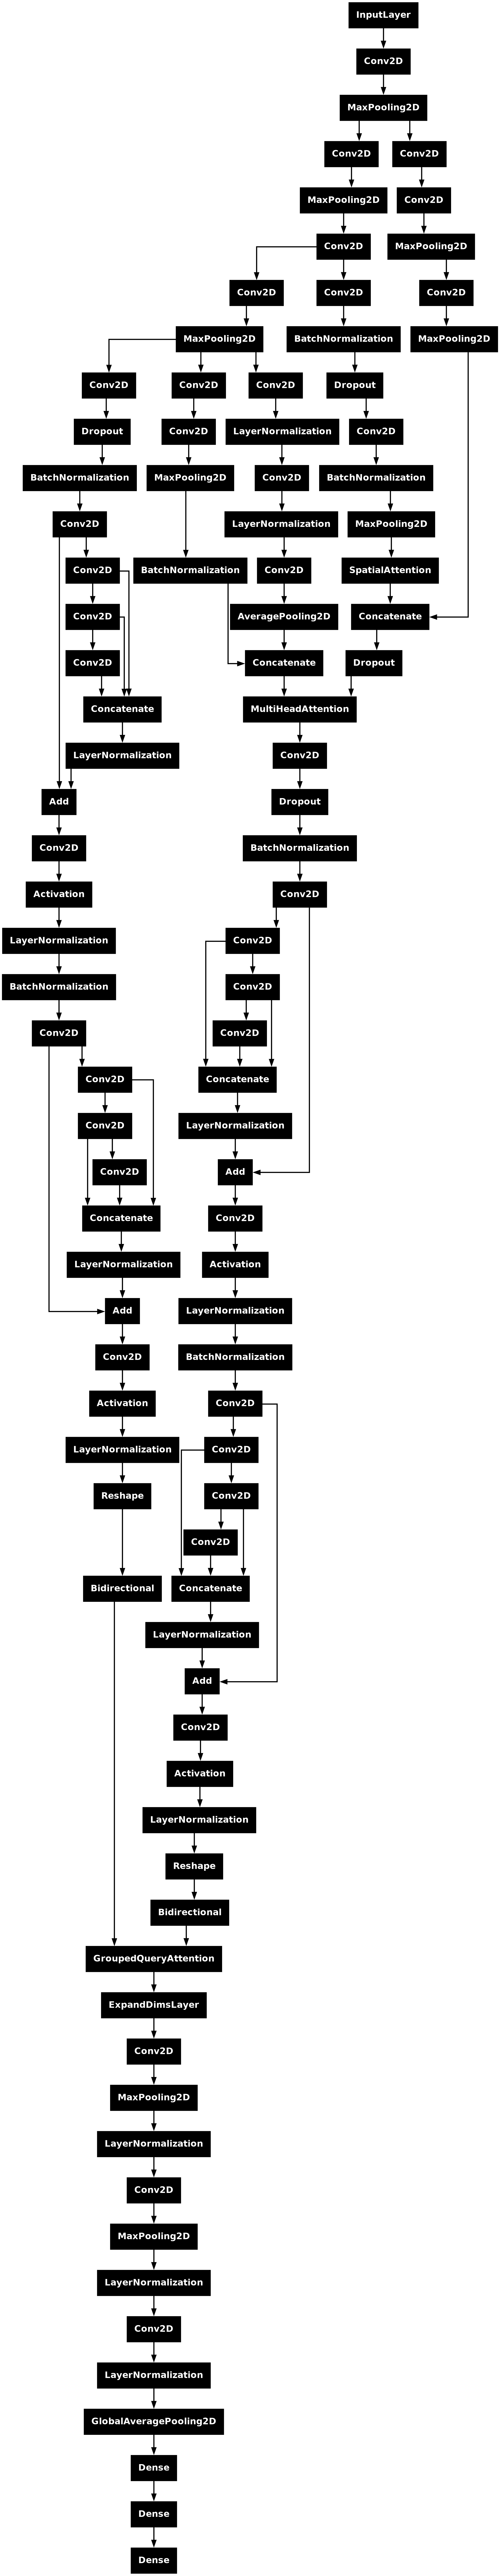

In [52]:
tf.keras.utils.plot_model(model, to_file='Proposed_Model.png')


In [53]:

from tensorflow.keras.callbacks import Callback 
class LearningRateSchedulerWithPatienceIoU(Callback):
    def __init__(self, reduce_lr_factor, patience, min_lr, monitor='val_iou'):
        super(LearningRateSchedulerWithPatienceIoU, self).__init__()
        self.reduce_lr_factor = reduce_lr_factor
        self.patience = patience
        self.min_lr = min_lr
        self.monitor = monitor
        self.wait = 0
        self.best_iou = -float('inf')
#         self.model = model
        
    def on_epoch_end(self, epoch, logs=None):
        current_iou = logs.get(self.monitor, -float('inf'))
        
        if current_iou > self.best_iou:
            self.best_iou = current_iou
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                new_lr = self.model.optimizer.learning_rate.numpy() * self.reduce_lr_factor
                print(new_lr)
                new_lr = max(new_lr, self.min_lr)
                
                self.model.optimizer.learning_rate.assign(new_lr)
                print(f"\nReduced learning rate to {new_lr} after {self.patience} epochs without improvement in IoU.\n")
                self.wait = 0





In [54]:
# initial_learning_rate = 0.00075  # Initial learning rate
# reduce_lr_factor = 0.5  # Factor by which to reduce the learning rate
# patience = 1  # Number of epochs without improvement in IoU before reducing learning rate
# min_learning_rate = 1e-6  # Minimum learning rate

# # Create the custom learning rate scheduler
# lr_scheduler = LearningRateSchedulerWithPatienceIoU(reduce_lr_factor, patience, min_learning_rate)

In [55]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_plateu = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=1)

In [56]:
all_train_one_hot.shape

(5724, 3)

In [57]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = "/kaggle/working/best_model_edited_run_5_october.keras"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


In [58]:

history = model.fit(all_train_images, all_train_one_hot,epochs=50, validation_data=(val_images, val_one_hot), batch_size=8, callbacks=[checkpoint, lr_plateu],verbose=1)


Epoch 1/50


2024-10-06 09:18:59.686794: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/dropout_3_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


716/716 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - AUC: 0.6586 - MAE: 0.4020 - MAPE: 200994576.0000 - Precision: 0.5861 - RMSE: 0.4457 - Recall: 0.2545 - accuracy: 0.5012 - f1_score: 0.3462 - false_negatives: 1975.4944 - false_positives: 515.2165 - loss: 0.9953
Epoch 1: val_accuracy improved from -inf to 0.24265, saving model to /kaggle/working/best_model_edited_run_5_october.keras
716/716 ━━━━━━━━━━━━━━━━━━━━ 121s 128ms/step - AUC: 0.6587 - MAE: 0.4019 - MAPE: 200973088.0000 - Precision: 0.5862 - RMSE: 0.4457 - Recall: 0.2546 - accuracy: 0.5013 - f1_score: 0.3464 - false_negatives: 1977.7684 - false_positives: 515.9512 - loss: 0.9952 - val_AUC: 0.6236 - val_MAE: 0.4399 - val_MAPE: 219938960.0000 - val_Precision: 0.4245 - val_RMSE: 0.4762 - val_Recall: 0.0551 - val_accuracy: 0.2426 - val_f1_score: 0.0976 - val_false_negatives: 771.0000 - val_false_positives: 61.0000 - val_loss: 1.1124 - learning_rate: 1.0000e-04
Epoch 2/50
716/716 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - AUC: 0.8050 - MAE: 0.308

In [59]:
import pandas as pd

history_df = pd.DataFrame()


for col in history.history.keys():
    history_df[col] = history.history[col]

history_df.head()
history_df.to_csv('./best_model_edited_run_5_october_accuracy.csv', index=False)

In [60]:
model.load_weights(checkpoint_path)

In [61]:
print(model.evaluate(all_train_images, all_train_one_hot))

179/179 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - AUC: 0.7741 - MAE: 4.9628e-04 - MAPE: 248140.2031 - Precision: 1.0000 - RMSE: 0.0023 - Recall: 1.0000 - accuracy: 1.0000 - f1_score: 1.0000 - false_negatives: 0.0000e+00 - false_positives: 0.0000e+00 - loss: 7.5102e-04
[0.0005199426086619496, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.00034567402326501906, 172836.25, 0.001329565653577447]


In [62]:
print(model.evaluate(val_images, val_one_hot))

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - AUC: 0.9960 - MAE: 0.0058 - MAPE: 2888952.5000 - Precision: 0.9941 - RMSE: 0.0615 - Recall: 0.9941 - accuracy: 0.9941 - f1_score: 0.9941 - false_negatives: 2.3704 - false_positives: 2.3704 - loss: 0.0335
[0.0260288268327713, 0.9950980544090271, 0.9950980544090271, 0.9950980544090271, 0.9972343444824219, 4.0, 4.0, 0.9950979948043823, 0.004854833707213402, 2427416.0, 0.057639893144369125]


In [63]:
print(model.evaluate(test_images, test_one_hot))

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - AUC: 0.9995 - MAE: 0.0049 - MAPE: 2444184.5000 - Precision: 0.9961 - RMSE: 0.0458 - Recall: 0.9961 - accuracy: 0.9961 - f1_score: 0.9961 - false_negatives: 2.7742 - false_positives: 2.7742 - loss: 0.0146
[0.023258235305547714, 0.9927083253860474, 0.9927083253860474, 0.9927083253860474, 0.9990536570549011, 7.0, 7.0, 0.9927082657814026, 0.0061622378416359425, 3081119.0, 0.0630410686135292]


In [64]:
print(model.evaluate(test_gen))

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


960/960 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - AUC: 0.9981 - MAE: 0.0048 - MAPE: 2383883.5000 - Precision: 0.9963 - RMSE: 0.0443 - Recall: 0.9963 - accuracy: 0.9963 - f1_score: 0.9963 - false_negatives: 2.5432 - false_positives: 2.5432 - loss: 0.0142
[0.023260723799467087, 0.9927083253860474, 0.9927083253860474, 0.9927083253860474, 0.9990528225898743, 7.0, 7.0, 0.9927082657814026, 0.006162658333778381, 3081330.75, 0.06304509937763214]


In [65]:
from tensorflow.keras.models import load_model
# model.save('kaggle-3-class-balanced-25-sep.keras')

dict_keys(['AUC', 'MAE', 'MAPE', 'Precision', 'RMSE', 'Recall', 'accuracy', 'f1_score', 'false_negatives', 'false_positives', 'loss', 'val_AUC', 'val_MAE', 'val_MAPE', 'val_Precision', 'val_RMSE', 'val_Recall', 'val_accuracy', 'val_f1_score', 'val_false_negatives', 'val_false_positives', 'val_loss', 'learning_rate'])


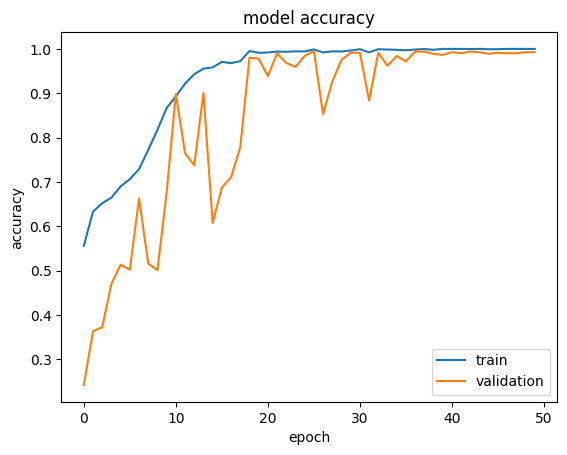

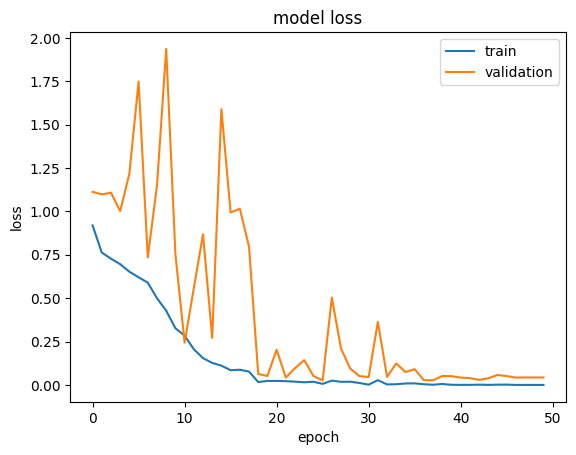

In [66]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [67]:
Y_prob = model.predict(test_images)
print(Y_prob)

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step
[[3.4788955e-04 1.2214312e-05 9.9963987e-01]
 [1.1608266e-04 9.9981004e-01 7.3862524e-05]
 [9.9904746e-01 7.8653666e-04 1.6598903e-04]
 ...
 [3.5104968e-04 1.4755715e-05 9.9963415e-01]
 [9.9764496e-01 2.1470687e-03 2.0803652e-04]
 [3.4691827e-04 1.0968178e-05 9.9964213e-01]]


In [68]:
y_pred = np.argmax(Y_prob, axis=1)
y_pred

array([2, 1, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 1, 2, 0, 2, 2, 1,
       0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 1, 0, 2, 2, 1, 0, 2, 2, 1, 1, 0, 0,
       2, 2, 2, 1, 2, 2, 2, 0, 0, 2, 2, 0, 1, 2, 2, 2, 2, 1, 2, 2, 0, 1,
       2, 1, 0, 0, 2, 2, 1, 0, 2, 2, 0, 2, 2, 2, 2, 2, 1, 0, 2, 2, 0, 2,
       0, 2, 1, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 1, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 2, 2, 0, 1, 2, 1, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 1, 1, 1,
       2, 2, 1, 0, 2, 1, 2, 0, 1, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 1, 2,
       1, 2, 2, 2, 2, 2, 1, 0, 0, 0, 2, 2, 2, 2, 1, 2, 0, 1, 0, 0, 1, 2,
       2, 2, 0, 2, 0, 1, 2, 2, 2, 0, 2, 0, 1, 2, 0, 0, 1, 0, 0, 2, 2, 2,
       2, 2, 2, 1, 2, 1, 0, 0, 1, 0, 2, 0, 1, 2, 2, 2, 0, 0, 1, 1, 0, 1,
       2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 1, 1, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 1, 2, 2, 1, 1, 2, 0, 2,
       0, 2, 1, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2,
       0, 2, 2, 0, 0, 1, 2, 0, 2, 2, 2, 1, 2, 0, 2,

In [69]:
np.argmax(test_one_hot, axis=1)

array([2, 1, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 1, 2, 0, 2, 2, 1,
       0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 1, 0, 2, 2, 1, 0, 2, 2, 1, 1, 0, 0,
       2, 2, 2, 1, 2, 2, 2, 0, 0, 2, 2, 0, 1, 2, 2, 2, 2, 1, 2, 2, 0, 1,
       2, 1, 0, 0, 2, 2, 1, 0, 2, 2, 0, 2, 2, 2, 2, 2, 1, 0, 2, 2, 0, 2,
       0, 2, 1, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 1, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 2, 2, 0, 1, 2, 1, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 1, 1, 1,
       2, 2, 1, 0, 2, 1, 2, 0, 1, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 1, 2,
       1, 2, 2, 2, 2, 2, 1, 0, 0, 0, 2, 2, 2, 2, 1, 2, 0, 1, 0, 0, 1, 2,
       2, 2, 0, 2, 0, 1, 2, 2, 2, 0, 2, 0, 1, 2, 0, 0, 1, 0, 0, 2, 2, 2,
       2, 2, 2, 1, 2, 1, 0, 0, 1, 0, 2, 0, 1, 2, 2, 2, 0, 0, 1, 1, 0, 1,
       2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 1, 1, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 1, 2, 2, 1, 1, 2, 0, 2,
       0, 2, 1, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2,
       0, 2, 2, 0, 0, 1, 2, 0, 2, 2, 2, 1, 2, 0, 2,

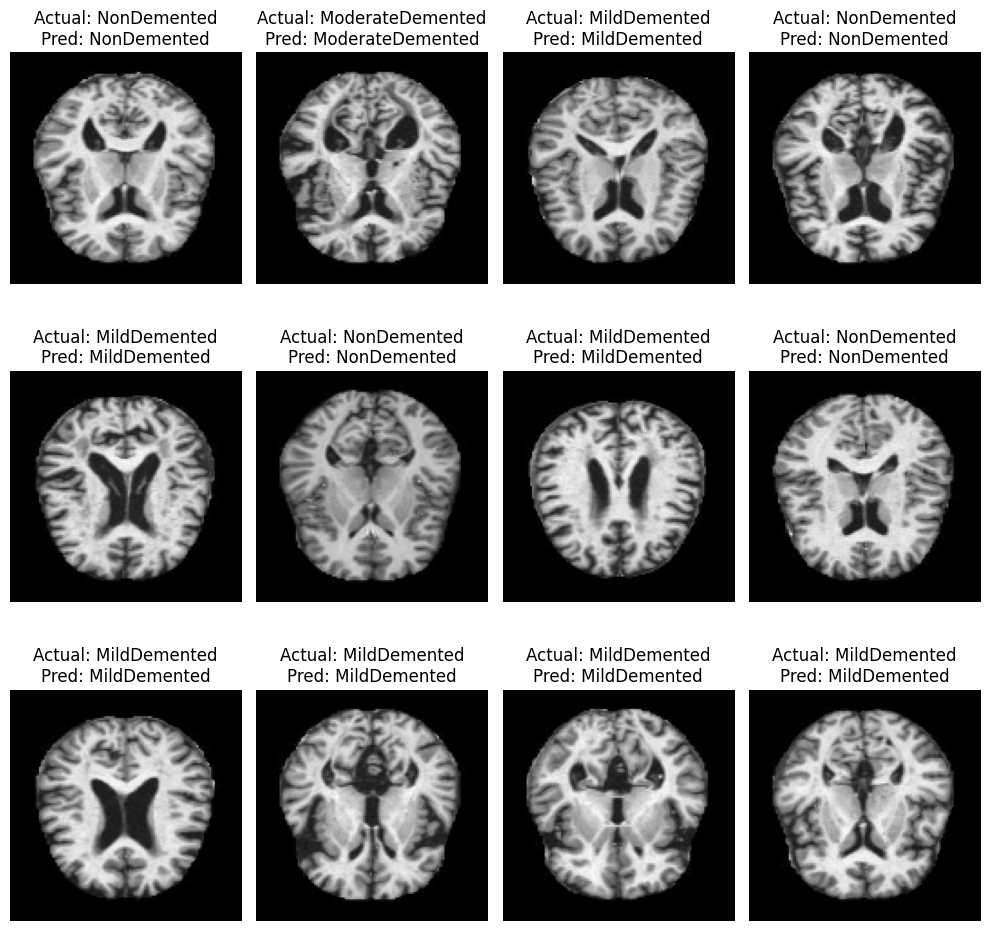

In [70]:
true_labels = np.argmax(test_one_hot, axis=1)


num_images = min(12, len(test_images))  # Ensure we don't exceed the number of images available
columns = 4
rows = (num_images + columns - 1) // columns  
fig = plt.figure(figsize=(10, 10))
label_names = classes  

for i in range(1, num_images + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(test_images[i - 1])
#     actual_label = label_names[true_labels[i - 1]]
    actual_label = label_names[test_encoded_labels[i - 1]]
    predicted_label = label_names[y_pred[i - 1]]
    plt.title(f'Actual: {actual_label}\nPred: {predicted_label}')
    plt.axis('off')  

plt.tight_layout()
plt.show()

In [71]:
from sklearn.metrics import classification_report


# Compute accuracy score
report = classification_report(test_encoded_labels, y_pred, target_names=classes)

# Print classification report
print("Classification Report:")
print(report)

Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.99      0.99      0.99       336
ModerateDemented       0.99      0.99      0.99       144
     NonDemented       0.99      1.00      0.99       480

        accuracy                           0.99       960
       macro avg       0.99      0.99      0.99       960
    weighted avg       0.99      0.99      0.99       960



In [72]:
def calculate_metrics(pred_classes, gt_classes):
    


    accuracy = np.mean(pred_classes == gt_classes)

   
    confusion_matrix = np.zeros((3, 3), dtype=int)
    np.add.at(confusion_matrix, (gt_classes, pred_classes), 1)

    sensitivity = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)

    true_negatives = np.sum(confusion_matrix) - np.sum(np.diag(confusion_matrix))
    specificity = true_negatives / (np.sum(confusion_matrix) - np.sum(np.diag(confusion_matrix)))

    metrics = {
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity
    }
    
    return metrics

In [73]:
print(calculate_metrics(y_pred, test_encoded_labels))

{'accuracy': 0.9927083333333333, 'sensitivity': array([0.98809524, 0.99305556, 0.99583333]), 'specificity': 1.0}


In [74]:
def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Reds', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = classes, 
        yticklabels = classes)
    
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()
    


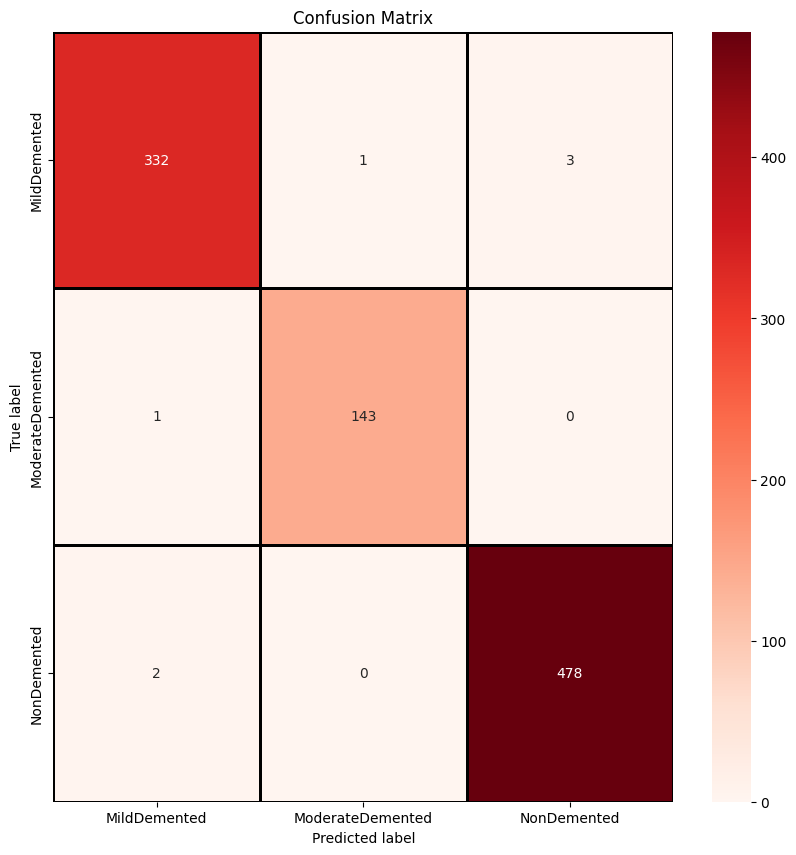

In [75]:
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(confusion_matrix(test_encoded_labels, y_pred))

In [76]:
def plot_confusion_matrix_perc(cm, classes):
    # Convert confusion matrix to percentages
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    plt.figure(figsize=(10, 10))
    sns.heatmap(
        cm_percentage, 
        cmap='Reds', 
        linecolor='black', 
        linewidth=1, 
        annot=True, 
        fmt='.2f',  # format the annotations to 2 decimal places
        xticklabels=classes, 
        yticklabels=classes
    )
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix (Percentage)')
    plt.show()

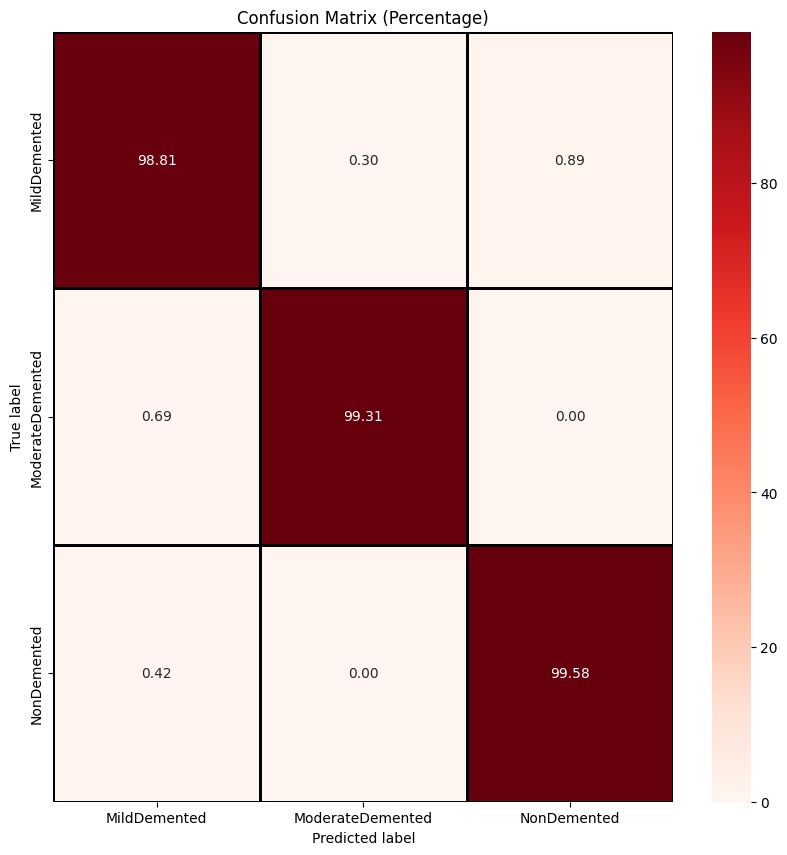

In [77]:
from sklearn.metrics import confusion_matrix
plot_confusion_matrix_perc(confusion_matrix(test_encoded_labels, y_pred), classes)